In [1]:
import pandas as pd
import autograd.numpy as np
from autograd import grad, jacobian
from scipy.stats import t
from gc_prop_calculation import y_pred_cal

In [553]:
df1 = pd.read_excel('data/excel_sp/Train_Tc.xlsx')
df2 = pd.read_excel('data/excel_sp/Test_Tc.xlsx')

In [579]:
df_concatenated = pd.concat([df1, df2], ignore_index=True)  

df_concatenated_filtered = df_concatenated.loc[:, (df_concatenated != 0).any(axis=0)]

df1_aft = df_concatenated_filtered.iloc[:len(df1)]  
df2_aft = df_concatenated_filtered.iloc[len(df1):] 

In [580]:
# df_raw = pd.read_excel('data/new_excels/Tc.xlsx')
# # extract target values
# df_target = df_raw['Const_Value']
# y = df_target.to_numpy()
# # extract all groups
# df_grp = df_raw.loc[:,'CH3':]
# df_grp = df_grp.iloc[:,:220+130+74]
# G = df_grp.to_numpy()
# # G = df_grp.loc[:, (df_grp != 0).any(axis=0)].to_numpy()

In [581]:
prop_tag = 'Tc'

In [594]:
df_raw = df_concatenated_filtered
# extract target values
df_target = df_raw['Const_Value']
y = df_target.to_numpy()
# extract all groups
df_grp = df_raw.loc[:,'CH3':]
G = df_grp.to_numpy()
# G = df_grp.loc[:, (df_grp != 0).any(axis=0)].to_numpy()

In [647]:
df_raw = df1_aft
# extract target values
df_target = df_raw['Const_Value']
y_tr = df_target.to_numpy()
# extract all groups
df_grp = df_raw.loc[:,'CH3':]
G_tr = df_grp.to_numpy()
# G = df_grp.loc[:, (df_grp != 0).any(axis=0)].to_numpy()

In [595]:
params_raw = pd.read_excel('data/theta_'+prop_tag+'.xlsx')

shape = G.shape
a,b = shape

theta_lm = params_raw.to_numpy().reshape(b+1,)
# theta_lm = params_raw['Values'].to_numpy().reshape(b+3,) #for omega

In [572]:
from sklearn.model_selection import train_test_split

df_raw_te = df2_aft

# extract target values
df_vt_target = df_raw_te['Const_Value']
# extract all groups
df_vt_grp = df_raw_te.loc[:,'CH3':]
df_vt_grp = df_vt_grp.iloc[:,:220+130+74]

# extract G
# G_vt = df_vt_grp.loc[:, (df_grp != 0).any(axis=0)].to_numpy()
G_vt = df_vt_grp.to_numpy()
# sog_vt = G_vt[:,nr_fog:nr_fog+nr_sog]
# tog_vt = G_vt[:,nr_fog+nr_sog:]
# extract y
y_vt_fog = df_vt_target.to_numpy()
#splitting the validation, test set

G_val, G_test, y_val, y_test = train_test_split(G_vt, y_vt_fog, test_size=0.5, random_state=42)

In [652]:
G = G_val
y = y_val

In [648]:
G_te = G_test
y_te = y_test

In [622]:
G = G_vt
y = y_vt_fog

In [654]:
G = np.concatenate((G_tr, G_te))
y = np.concatenate((y_tr, y_te))

In [655]:
y_pred_lm = y_pred_cal(G, theta_lm[0], theta_lm[1:], 0, 0, prop_tag) 

In [651]:
from gc_aux import r2_score
from sklearn.metrics import mean_absolute_error

tog_0_r2 = r2_score(y,y_pred_lm)
tog_0_mae = mean_absolute_error(y,y_pred_lm)
tog_0_are = np.average(np.abs((y - y_pred_lm) / y))*100
# printing

print('mae of tog:' + str(tog_0_mae))
print('r2 of tog:' + str(tog_0_r2))
print('are of tog:' + str(tog_0_are))

mae of tog:15.249419678819732
r2 of tog:0.9315386566869676
are of tog:2.4223056430477765


get theta

In [457]:
df_theta_grp = pd.DataFrame(columns=['Groups'])
df_theta_all = pd.DataFrame(columns=['Groups'])

df_grp_0 = df_grp
df_grp_1 = df_grp.loc[:, (df_grp != 0).any(axis=0)]

df_theta_all.at[0, 'Groups'] = 'Universal constant 1'
# df_theta_grp.at[1, 'Groups'] = 'Universal constant 2'
# df_theta_grp.at[2, 'Groups'] = 'Universal constant 3'
df_theta_all.at[1, 'Groups'] = df_grp_0.columns.tolist()
df_theta_all = df_theta_all['Groups'].explode().reset_index(drop=True)
df_theta_all = df_theta_all.to_frame(name='Groups')

df_theta_grp.at[0, 'Groups'] = 'Universal constant 1'
# df_theta_grp.at[1, 'Groups'] = 'Universal constant 2'
# df_theta_grp.at[2, 'Groups'] = 'Universal constant 3'
df_theta_grp.at[1, 'Groups'] = df_grp_1.columns.tolist()
df_theta_grp = df_theta_grp['Groups'].explode().reset_index(drop=True)

df_theta_1 = pd.DataFrame({'Groups': df_theta_grp, 'Values': theta_lm})
theta_mapping = ['Values']
df_theta_all = df_theta_all.merge(df_theta_1[['Groups'] + theta_mapping], on='Groups', how='outer')
df_theta_all.fillna(0, inplace=True)

df_theta_all.to_excel('data/theta_'+prop_tag+'.xlsx', index=False)

analysis starts here

In [656]:
def model_cost(theta, y):
    
    y_pred = y_pred_cal(G, theta[0], theta[1:], 0, 0, prop_tag)
#     y_pred = y_pred_cal(G, [theta[0], theta[1], theta[2]], theta[3:], 0, 0, prop_tag) 
    
    error = y - y_pred
    return error

jacobian_matrix = jacobian(model_cost)
jacobian_value = jacobian_matrix(theta_lm, y)
J = jacobian_value

In [657]:
jacobian_value.shape

(1772, 297)

In [658]:
y_pred_lm = y_pred_cal(G, theta_lm[0], theta_lm[1:], 0, 0, prop_tag)
# y_pred_lm = y_pred_cal(G, [theta_lm[0], theta_lm[1], theta_lm[2]], theta_lm[3:], 0, 0, prop_tag) 

resd = y - y_pred_lm

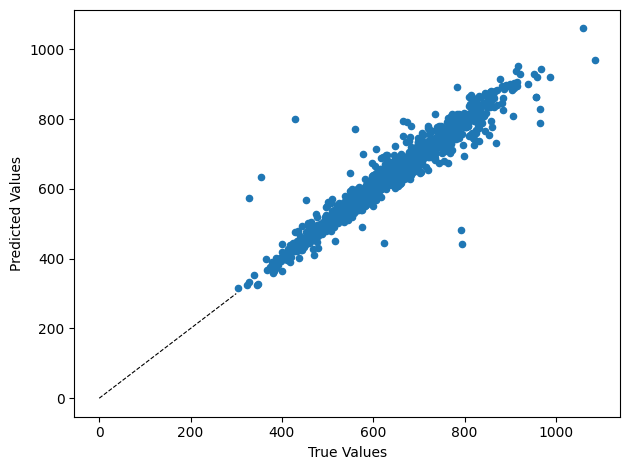

In [659]:
import matplotlib.pyplot as plt
# plot
plt.scatter(y,y_pred_lm,s=20)
plt.plot([0, 300], [0, 300], color='black', linestyle='--',linewidth=0.8)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# plt.xlim(0, 3)
# plt.ylim(0, 3)
plt.tight_layout()

# plt.savefig('Parity Plot of y_lm_tog and y_true for '+prop_tag+'.pdf')
plt.show()

In [660]:
s=np.matmul(np.transpose(resd),resd)/(a-b-1)
print(s)

876.4466129444479


In [661]:
p_cov=np.linalg.pinv(np.matmul(np.transpose(J),J))*s
print(p_cov)

[[ 5.29772890e+01 -2.95695083e-01 -7.52930855e-01 ...  0.00000000e+00
  -1.21211269e+01  2.92548894e+00]
 [-2.95695083e-01  5.37677000e-03  3.72159407e-03 ...  0.00000000e+00
   6.66165415e-02 -1.69386172e-02]
 [-7.52930855e-01  3.72159407e-03  1.09452429e-02 ...  0.00000000e+00
   1.72451657e-01 -4.17550278e-02]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.21211269e+01  6.66165415e-02  1.72451657e-01 ...  0.00000000e+00
   1.22299094e+01 -6.67180338e-01]
 [ 2.92548894e+00 -1.69386172e-02 -4.17550278e-02 ...  0.00000000e+00
  -6.67180338e-01  4.55102884e+00]]


In [665]:
param_se = np.sqrt(np.diag(p_cov))
print(param_se)

[7.27854992e+00 7.33264618e-02 1.04619515e-01 1.81816737e-01
 3.08480752e-01 3.17107254e-01 6.14442350e-01 6.06667768e-01
 9.40253915e-01 1.43082301e+00 5.73736121e-01 9.38774197e-01
 2.98668886e-01 5.36520518e-01 1.48637115e-01 1.58096012e+00
 8.62109090e-01 4.04687474e+00 7.05309253e-01 3.44539730e-01
 3.70647357e-01 8.26742247e-01 9.29723403e-01 6.92718939e-01
 1.22506492e+00 1.16637551e+00 1.75073267e+00 3.72901007e-01
 7.77913945e-01 7.87169802e-01 1.75174845e+00 4.78074824e-01
 4.96972919e-01 1.05071440e+00 1.11211671e+00 1.47515761e+00
 3.74293684e-01 1.03058436e+00 4.70361209e-01 4.61254764e-01
 6.65228480e-01 8.94201121e-01 4.37358546e-01 7.54638060e-01
 1.65060508e+00 5.45615364e-01 2.13719261e-01 2.07926263e-01
 4.46855380e-01 4.55067385e-01 6.11886166e-01 4.55652062e-01
 5.52891485e-01 6.71818683e-01 5.05101834e-01 4.08758163e-01
 1.04080356e+00 3.92356982e-01 4.08749917e-01 9.85071651e-01
 1.62190495e+00 1.30649580e+00 1.06305065e+00 8.42648268e-01
 1.30825215e+00 2.551146

In [666]:
p_cor = p_cov/np.matmul(np.transpose(param_se),param_se)

In [667]:
tcr = t.ppf(1-0.025,a-b-1)
tcr

1.9613838172207607

In [668]:
p95_lower = theta_lm - tcr * param_se
p95_upper = theta_lm + tcr * param_se

p95 = np.vstack((p95_lower, p95_upper)).T
print(p95)

[[ 2.33582583e+02  2.62134643e+02]
 [ 1.88140518e+00  2.16904785e+00]
 [ 7.66701448e-01  1.17709950e+00]
 [-7.68799517e-01 -5.55747055e-02]
 [-2.16886272e+00 -9.58764408e-01]
 [ 2.25320656e+00  3.49714464e+00]
 [ 4.08077168e-01  2.81839173e+00]
 [ 4.79135371e-01  2.85895206e+00]
 [-9.33568176e-01  2.75482945e+00]
 [-3.02909307e+00  2.58369312e+00]
 [ 3.17285410e+00  5.42348759e+00]
 [ 1.36036498e+00  5.04295802e+00]
 [ 2.75250176e+00  3.92411040e+00]
 [ 2.08452118e+00  4.18916651e+00]
 [ 1.54007073e+00  2.12313959e+00]
 [-1.57713973e+01 -9.56965810e+00]
 [ 2.82057754e+01  3.15876291e+01]
 [-7.25890432e+00  8.61604493e+00]
 [ 8.15840856e-01  3.58260516e+00]
 [ 2.15709702e+00  3.50864632e+00]
 [ 6.90880253e-01  2.14484371e+00]
 [-2.00696702e+00  1.23615071e+00]
 [-3.53257250e+00  1.14516375e-01]
 [ 3.28189478e+00  5.99927021e+00]
 [ 1.49853304e+00  6.30417805e+00]
 [ 1.16827696e+00  5.74369706e+00]
 [ 1.25333135e+00  8.12104880e+00]
 [ 4.29551968e+00  5.75832368e+00]
 [ 4.96466138e+00  8

In [669]:
y_cov = np.matmul(np.matmul(J, p_cov),np.transpose(J))

In [670]:
y_sigma = np.sqrt(np.abs(np.diag(y_cov)))

print(y_sigma)

[3.39565157 6.68271729 8.21708919 ... 8.33549767 3.61126106 6.92263893]


In [671]:
y95_lower = y_pred_lm - y_sigma * tcr  
y95_upper = y_pred_lm + y_sigma * tcr

y95 = np.vstack((y95_lower, y95_upper)).T

print(y95)

[[663.60679744 676.92714953]
 [544.10518449 570.31993159]
 [375.88611265 408.11984417]
 ...
 [609.96556688 642.66378734]
 [781.56296892 795.72910692]
 [524.52969279 551.68559674]]


save

In [672]:
df_theta_grp = pd.DataFrame(columns=['Groups'])
df_theta_all = pd.DataFrame(columns=['Groups'])

df_grp_0 = df_grp
df_grp_1 = df_grp
# df_grp_1 = df_grp.loc[:, (df_grp != 0).any(axis=0)]

df_theta_all.at[0, 'Groups'] = 'Universal constant 1'
# df_theta_grp.at[1, 'Groups'] = 'Universal constant 2'
# df_theta_grp.at[2, 'Groups'] = 'Universal constant 3'
df_theta_all.at[1, 'Groups'] = df_grp_0.columns.tolist()
df_theta_all = df_theta_all['Groups'].explode().reset_index(drop=True)
df_theta_all = df_theta_all.to_frame(name='Groups')

df_theta_grp.at[0, 'Groups'] = 'Universal constant 1'
# df_theta_grp.at[1, 'Groups'] = 'Universal constant 2'
# df_theta_grp.at[2, 'Groups'] = 'Universal constant 3'
df_theta_grp.at[1, 'Groups'] = df_grp_1.columns.tolist()
df_theta_grp = df_theta_grp['Groups'].explode().reset_index(drop=True)

df_theta_1 = pd.DataFrame({'Groups': df_theta_grp, 'Values': theta_lm, 'Theta95_low': p95_lower, 'Theta95_high': p95_upper})
theta_mapping = ['Values', 'Theta95_low', 'Theta95_high']
df_theta_all = df_theta_all.merge(df_theta_1[['Groups'] + theta_mapping], on='Groups', how='right')
df_theta_all.fillna(0, inplace=True)

with pd.ExcelWriter(prop_tag+'_Results.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_theta_all.to_excel(writer, sheet_name='Group Contribution', index=False)

In [673]:
df_y = pd.DataFrame()

df_y['SMILES'] = df_raw['SMILES']
df_y['y_exp'] = y.flatten()
df_y['y_pred'] = y_pred_lm.flatten()
df_y['y95_low'] = y95_lower.flatten()
df_y['y95_high'] = y95_upper.flatten()

with pd.ExcelWriter(prop_tag+'_Results.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_y.to_excel(writer, sheet_name='y', index=False)

ValueError: Length of values (1772) does not match length of index (1574)

In [621]:
y_pred_train = y_pred_lm
errors_tr = np.sqrt(np.abs(np.diag(y_cov)))* tcr 

In [528]:
y_pred_val = y_pred_lm
errors_va = np.sqrt(np.abs(np.diag(y_cov)))* tcr 

In [640]:
y_pred_te = y_pred_lm
errors_te = np.sqrt(np.abs(np.diag(y_cov)))* tcr 

ends here

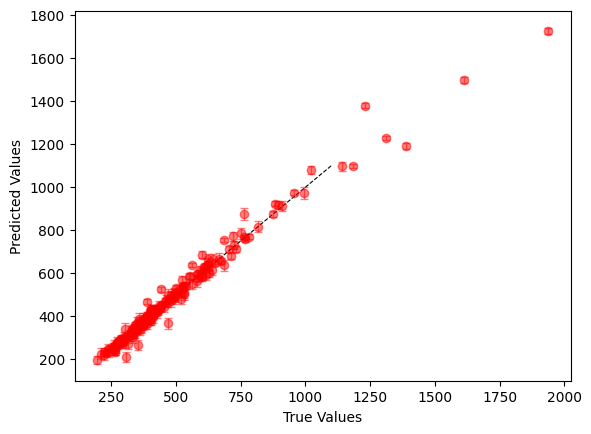

In [546]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

errors = np.sqrt(np.abs(np.diag(y_cov)))* tcr 

# y = y*1000 # for Vc dataset only

plt.errorbar(y, y_pred_lm, yerr=errors,fmt='o', color='red', ecolor='red', elinewidth=1, capsize=3, alpha=0.5)

plt.plot([300, 1100], [300, 1100], color='black', linestyle='--',linewidth=0.8)


# plt.legend()

plt.xlabel('True Values')
plt.ylabel('Predicted Values')

plt.savefig('linear/'+prop_tag+'_1.pdf')

plt.show()

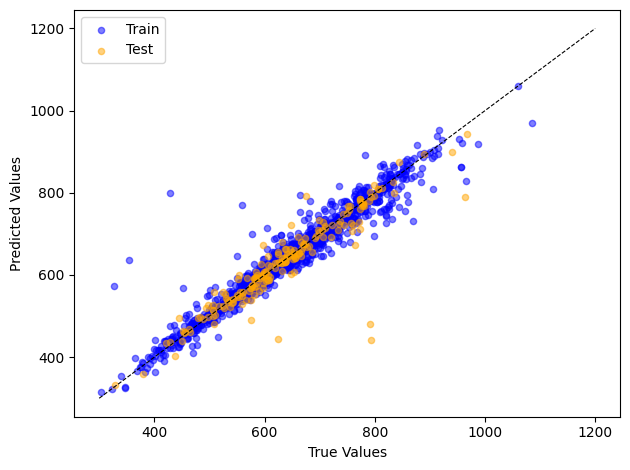

In [643]:
y_train = df_target.to_numpy()

plt.scatter(y_train, y_pred_train, color='blue',s=20, alpha=0.5, label='Train')
# plt.scatter(y_val, y_pred_val, color='purple', s=20, alpha=0.5, label='Validation')
plt.scatter(y_test, y_pred_te, color='orange',s=20, alpha=0.5, label='Test')

plt.plot([300, 1200], [300, 1200], color='black', linestyle='--',linewidth=0.8)

# plt.xlim(0, 100)
# plt.ylim(0, 100)

plt.legend(loc='upper left') 

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()

plt.savefig('linear/'+prop_tag+'_1.pdf')

plt.show()

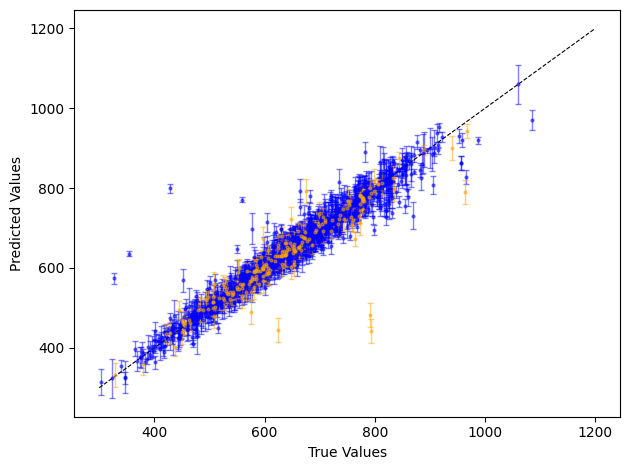

In [645]:
plt.errorbar(y_train, y_pred_train, yerr=errors_tr, fmt='o', color='blue', markersize=2,ecolor='blue', elinewidth=1, capsize=2, alpha=0.5, label='Test')
# plt.errorbar(y_val, y_pred_val, yerr=errors_va, fmt='o', color='purple', markersize=2,ecolor='purple', elinewidth=1, capsize=2, alpha=0.5, label='Test')
plt.errorbar(y_test, y_pred_te, yerr=errors_te, fmt='o', color='orange', markersize=2,ecolor='orange', elinewidth=1, capsize=2, alpha=0.5, label='Test')

plt.plot([300, 1200], [300, 1200], color='black', linestyle='--',linewidth=0.8)

# plt.xlim(0, 100)
# plt.ylim(0, 100)

# plt.legend()

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()

plt.savefig('linear/'+prop_tag+'_2.pdf')

plt.show()